In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, ReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
import os
from numpy import load


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
print("Version de TensorFlow :", tf.__version__)
print("GPU disponible :", tf.config.list_physical_devices('GPU'))

Version de TensorFlow : 2.15.0
GPU disponible : []


In [4]:
def load_image(file_path, target_size=(256, 256)):
    """
    Load and resize an image to the target size.
    """
    image = Image.open(file_path).convert('RGB')
    image = image.resize(target_size)
    image = np.array(image).astype('float32') / 127.5 - 1  # Normalize to [-1, 1]
    return image

In [5]:
def load_and_align_datasets(input_dir, target_dir, target_size=(256, 256)):
    """
    Charge les images des répertoires spécifiés, les redimensionne et les aligne pour avoir le même nombre d'images.

    :param input_dir: Répertoire contenant les images normales.
    :param target_dir: Répertoire contenant les images cartoonisées.
    :param target_size: Taille cible pour le redimensionnement.
    :return: Deux listes numpy contenant les images alignées.
    """
    # Charger les chemins des fichiers
    input_images = sorted(glob.glob(os.path.join(input_dir, '*.jpg')))
    target_images = sorted(glob.glob(os.path.join(target_dir, '*.jpg')))

    # S'assurer que les deux ensembles ont le même nombre d'images
    min_size = min(len(input_images), len(target_images))
    input_images = input_images[:min_size]
    target_images = target_images[:min_size]

    # Charger et redimensionner les images
    input_data = [load_image(img, target_size) for img in input_images]
    target_data = [load_image(img, target_size) for img in target_images]

    return np.array(input_data), np.array(target_data)

In [6]:

import tensorflow as tf
import numpy as np
from os import listdir
import os
import re

# Function to extract numerical part from a filename
def extract_number(filename):
    match = re.search(r'\d+', filename)  # Extract digits
    return int(match.group()) if match else -1

# Function to load and align images in a directory
def load_images(path, size=(256, 256)):
    # Paths to input and target directories
    input_list = os.path.join(path, "real")  # Adjust folder names as needed
    target_list = os.path.join(path, "cartoon")

    # Get filenames and sort by extracted number
    input_files = sorted(listdir(input_list), key=extract_number)
    target_files = sorted(listdir(target_list), key=extract_number)

    src_list, tar_list = [], []

    # Ensure both directories have the same number of files
    if len(input_files) != len(target_files):
        raise ValueError("Number of input and target images does not match!")

    # Iterate through sorted filenames
    for input_file, target_file in zip(input_files, target_files):
        # Load and resize input image
        input_path = os.path.join(input_list, input_file)
        input_img = tf.keras.utils.load_img(input_path, target_size=size)
        src_list.append(np.array(input_img))

        # Load and resize target image
        target_path = os.path.join(target_list, target_file)
        target_img = tf.keras.utils.load_img(target_path, target_size=size)
        tar_list.append(np.array(target_img))

    return np.asarray(src_list), np.asarray(tar_list)

# Dataset path
path = 'train'

# Load the dataset
src_images, tar_images = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)

# Save as compressed numpy array
filename = 'basket.npz'
np.savez_compressed(filename, src_images=src_images, tar_images=tar_images)
print('Saved dataset: ', filename)


Loaded:  (260, 256, 256, 3) (260, 256, 256, 3)
Saved dataset:  basket.npz


In [7]:
def build_generator():
    inputs = Input(shape=[256, 256, 3])

    # Encoder
    down1 = Conv2D(64, 4, strides=2, padding='same')(inputs)
    down1 = LeakyReLU(0.2)(down1)

    down2 = Conv2D(128, 4, strides=2, padding='same')(down1)
    down2 = BatchNormalization()(down2)
    down2 = LeakyReLU(0.2)(down2)

    down3 = Conv2D(256, 4, strides=2, padding='same')(down2)
    down3 = BatchNormalization()(down3)
    down3 = LeakyReLU(0.2)(down3)

    # Decoder
    up1 = Conv2DTranspose(128, 4, strides=2, padding='same')(down3)
    up1 = BatchNormalization()(up1)
    up1 = ReLU()(up1)
    up1 = Concatenate()([up1, down2])

    up2 = Conv2DTranspose(64, 4, strides=2, padding='same')(up1)
    up2 = BatchNormalization()(up2)
    up2 = ReLU()(up2)
    up2 = Concatenate()([up2, down1])

    outputs = Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(up2)

    return Model(inputs, outputs)

In [8]:
# Discriminator Model
def build_discriminator():
    input_image = Input(shape=[256, 256, 3])
    target_image = Input(shape=[256, 256, 3])

    x = Concatenate()([input_image, target_image])
    #64
    x = Conv2D(64, 4, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    #128
    x = Conv2D(128, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    #256
    x = Conv2D(256, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    #512
    x = Conv2D(512, 4, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    # patch output
    x = Conv2D(1, 4, strides=1, padding='same', activation='sigmoid')(x)
    # define model
    return Model([input_image, target_image], x)

In [9]:
# Loss Functions
def adversarial_loss(disc_generated_output):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(disc_generated_output), disc_generated_output))

In [10]:
# def l1_loss(gen_output, target):
#     return tf.reduce_mean(tf.abs(target - gen_output))
def l1_loss(gen_output, target):
    target = tf.cast(target, tf.float32)  # Cast target to float32
    return tf.reduce_mean(tf.abs(target - gen_output))


In [11]:
def generator_loss(disc_generated_output, gen_output, target, lambda_l1=100):
    adv_loss = adversarial_loss(disc_generated_output)
    l1 = l1_loss(gen_output, target)
    return adv_loss + lambda_l1 * l1

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output))
    fake_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output))
    return real_loss + fake_loss

In [13]:
generator = build_generator()
discriminator = build_discriminator()

# Optimizers
gen_optimizer = Adam(2e-4, beta_1=0.5)
disc_optimizer = Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(input_image, target_image, generator, discriminator, gen_optimizer, disc_optimizer, lambda_l1=100):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        # Discriminator outputs
        real_output = discriminator([input_image, target_image], training=True)
        fake_output = discriminator([input_image, gen_output], training=True)

        # Compute losses
        gen_loss = generator_loss(fake_output, gen_output, target_image, lambda_l1)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Compute gradients
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients (ensure these optimizers are initialized outside the function)
    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [14]:
def train(dataset, generator, discriminator, gen_optimizer, disc_optimizer, epochs=10):
    gen_losses = []
    disc_losses = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_gen_loss = []
        epoch_disc_loss = []

        for input_image, target_image in dataset:
            gen_loss, disc_loss = train_step(input_image, target_image, generator, discriminator, gen_optimizer, disc_optimizer)
            print(f"Step Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}")  # Débogage des pertes
            epoch_gen_loss.append(gen_loss.numpy())
            epoch_disc_loss.append(disc_loss.numpy())

        gen_losses.append(np.mean(epoch_gen_loss))
        disc_losses.append(np.mean(epoch_disc_loss))

        print(f"Epoch {epoch + 1}: Gen Loss = {gen_losses[-1]:.4f}, Disc Loss = {disc_losses[-1]:.4f}")

    # Vérification des données avant tracé
    if not gen_losses or not disc_losses:
        print("Erreur : Les pertes sont vides. Vérifiez les étapes de calcul.")
        return

    # Plot learning curves
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label="Generator Loss")
    plt.plot(disc_losses, label="Discriminator Loss")
    plt.title("Learning Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("learning_curves.png")  # Sauvegarde les courbes
    plt.show()


In [15]:
# Apply the model to new images
def cartoonify_image(generator, image_path, target_size=(256, 256)):
    input_image = load_image(image_path, target_size)
    generated_image = generator(input_image[tf.newaxis, ...], training=False)
    generated_image = ((generated_image.numpy().squeeze() + 1) / 2 * 255).astype('uint8')
    return Image.fromarray(generated_image)

Loaded:  (260, 256, 256, 3) (260, 256, 256, 3)
Epoch 1/100
Step Gen Loss: 7285.92041015625, Disc Loss: 1.6047788858413696
Step Gen Loss: 7932.98876953125, Disc Loss: 3.4266018867492676
Step Gen Loss: 7045.30859375, Disc Loss: 1.8984390497207642
Step Gen Loss: 8285.46484375, Disc Loss: 1.3731040954589844
Step Gen Loss: 6290.37744140625, Disc Loss: 1.3970825672149658
Step Gen Loss: 7751.0615234375, Disc Loss: 1.318779706954956
Step Gen Loss: 7267.03125, Disc Loss: 1.2890303134918213
Step Gen Loss: 6972.41796875, Disc Loss: 1.2954015731811523
Step Gen Loss: 7196.794921875, Disc Loss: 1.2434020042419434
Step Gen Loss: 6530.65966796875, Disc Loss: 1.2166554927825928
Step Gen Loss: 6397.04345703125, Disc Loss: 1.167328953742981
Step Gen Loss: 7043.68359375, Disc Loss: 1.1425156593322754
Step Gen Loss: 6480.9462890625, Disc Loss: 1.1411819458007812
Step Gen Loss: 6907.0263671875, Disc Loss: 1.0074825286865234
Step Gen Loss: 6289.70849609375, Disc Loss: 1.0623197555541992
Step Gen Loss: 6041.7

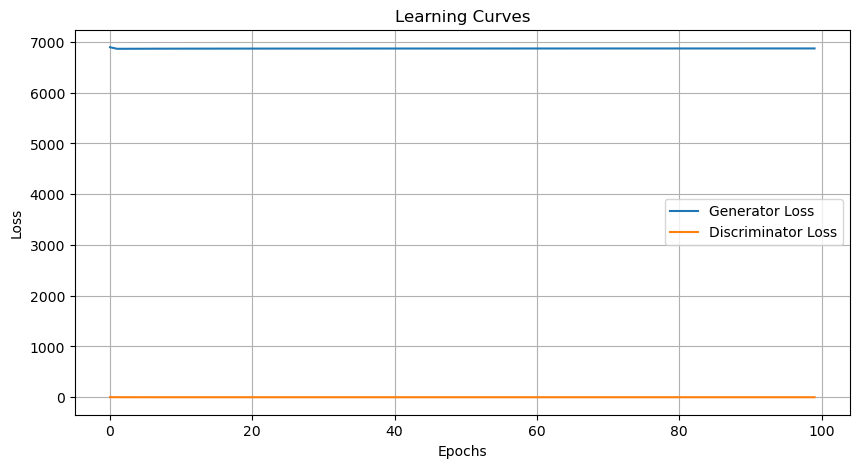

Training Complete!


In [16]:
from sklearn.model_selection import train_test_split

# load the dataset
data = load('basket.npz')

input_images, target_images = data['src_images'], data['tar_images']
print('Loaded: ', src_images.shape, tar_images.shape)

# Split into train and test sets
input_train, input_test, target_train, target_test = train_test_split(
    input_images, target_images, test_size=0.2, random_state=42
)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((input_train, target_train)).shuffle(1000).batch(8)
test_dataset = tf.data.Dataset.from_tensor_slices((input_test, target_test)).batch(8)

# Build models
generator = build_generator()
discriminator = build_discriminator()

# Optimizers
gen_optimizer = Adam(2e-4, beta_1=0.5)
disc_optimizer = Adam(2e-4, beta_1=0.5)

# Train
train(train_dataset,
    generator,
    discriminator,
    gen_optimizer,
    disc_optimizer,
    epochs=100
)
print("Training Complete!")

In [17]:
# Evaluate on the test set (Optional)
print("Evaluating on test dataset...")
for input_image, target_image in test_dataset:
    generated_image = generator(input_image, training=False)
    # Add evaluation metrics here (e.g., SSIM, PSNR, etc.)

# Save the models
generator.save("generator_model.keras")
discriminator.save("discriminator_model.keras")

print("Evaluation and model saving Complete!")

Evaluating on test dataset...
Evaluation and model saving Complete!


In [21]:
# Test on a new image
test_image_path = "test/"
for test_image in listdir(test_image_path):
    result_image = cartoonify_image(generator, test_image_path+test_image)
    result_image.show()


KeyboardInterrupt: 

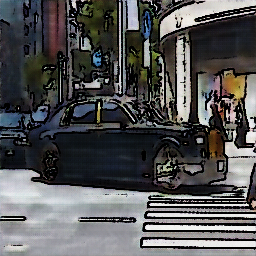

In [97]:
result_image